# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
import xgboost as xgb
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10000)

# Ingest Data

In [2]:
# Import SF buyout data
SF_buy = pd.read_csv('/Users/mattcarney/Documents/SF_Buyout/Buyout_agreements.csv')

In [3]:
# Import SF home value data
#home_value = pd.read_csv('/Users/mattcarney/Documents/SF_Buyout/Neighborhood_Zhvi_Summary_AllHomes.csv')

# EDA

In [4]:
SF_buy.shape
#SF_buy.head(100).sort_values('Buyout Agreement Date', ascending=True )

(1326, 25)

In [5]:
buyout = SF_buy.drop(columns=[':@computed_region_fyvs_ahh9',':@computed_region_p5aj_wyqh',
                             ':@computed_region_rxqg_mtj9', ':@computed_region_yftq_j783',
                             ':@computed_region_bh8s_q3mv', ':@computed_region_6pnf_4xz7',
                             ':@computed_region_6ezc_tdp2', ':@computed_region_viu7_rrfi',
                             ':@computed_region_n4xg_c4py', 'Pre Buyout Disclosure Date', 
                             'Unknown Amount', 'Other Consideration', 
                             'Block Address', 'the_geom', 'SF Find Neighborhoods',
                             'Current Police Districts', 'Current Supervisor Districts',
                             'Analysis Neighborhoods', 'Case Number', 'Buyout Agreement Date', 'Supervisor District'])

buyout = buyout.rename(columns = {'Analysis Neighborhood':'Neighborhood'})
buyout['ZIP Code'] = buyout['ZIP Code'].astype(str)
buyout = buyout.loc[buyout['Number of Tenants']<10]
buyout = buyout.dropna()

In [6]:
buyout.shape

(1311, 4)

In [7]:
buyout.describe()

,Buyout Amount,Number of Tenants
count,1311.000000,1311.000000
mean,42131.714485,1.897025
std,38690.836723,1.134840
min,0.000000,1.000000
25%,17000.000000,1.000000
50%,30000.000000,2.000000
75%,54608.995000,2.000000
max,310000.000000,8.000000


In [8]:
buyout.groupby('Neighborhood').mean().sort_values('Buyout Amount', ascending=False)

,Buyout Amount,Number of Tenants
Neighborhood,,
Financial District/South Beach,138000.000000,2.000000
Tenderloin,130519.230769,1.307692
Mission,54229.955960,2.066225
Lone Mountain/USF,54003.972000,2.266667
Noe Valley,53755.556949,1.881356
Castro/Upper Market,50821.699459,1.608108
Seacliff,49034.400000,2.000000
Russian Hill,48761.873889,1.694444
Marina,48573.402000,1.654545


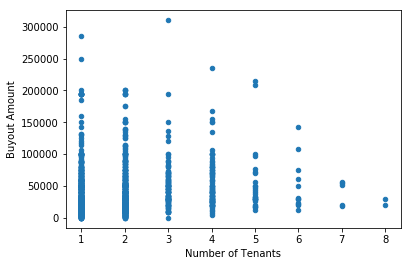

In [9]:
# Buyout amount vs number of tenants
buyout.plot.scatter(x='Number of Tenants', y='Buyout Amount')

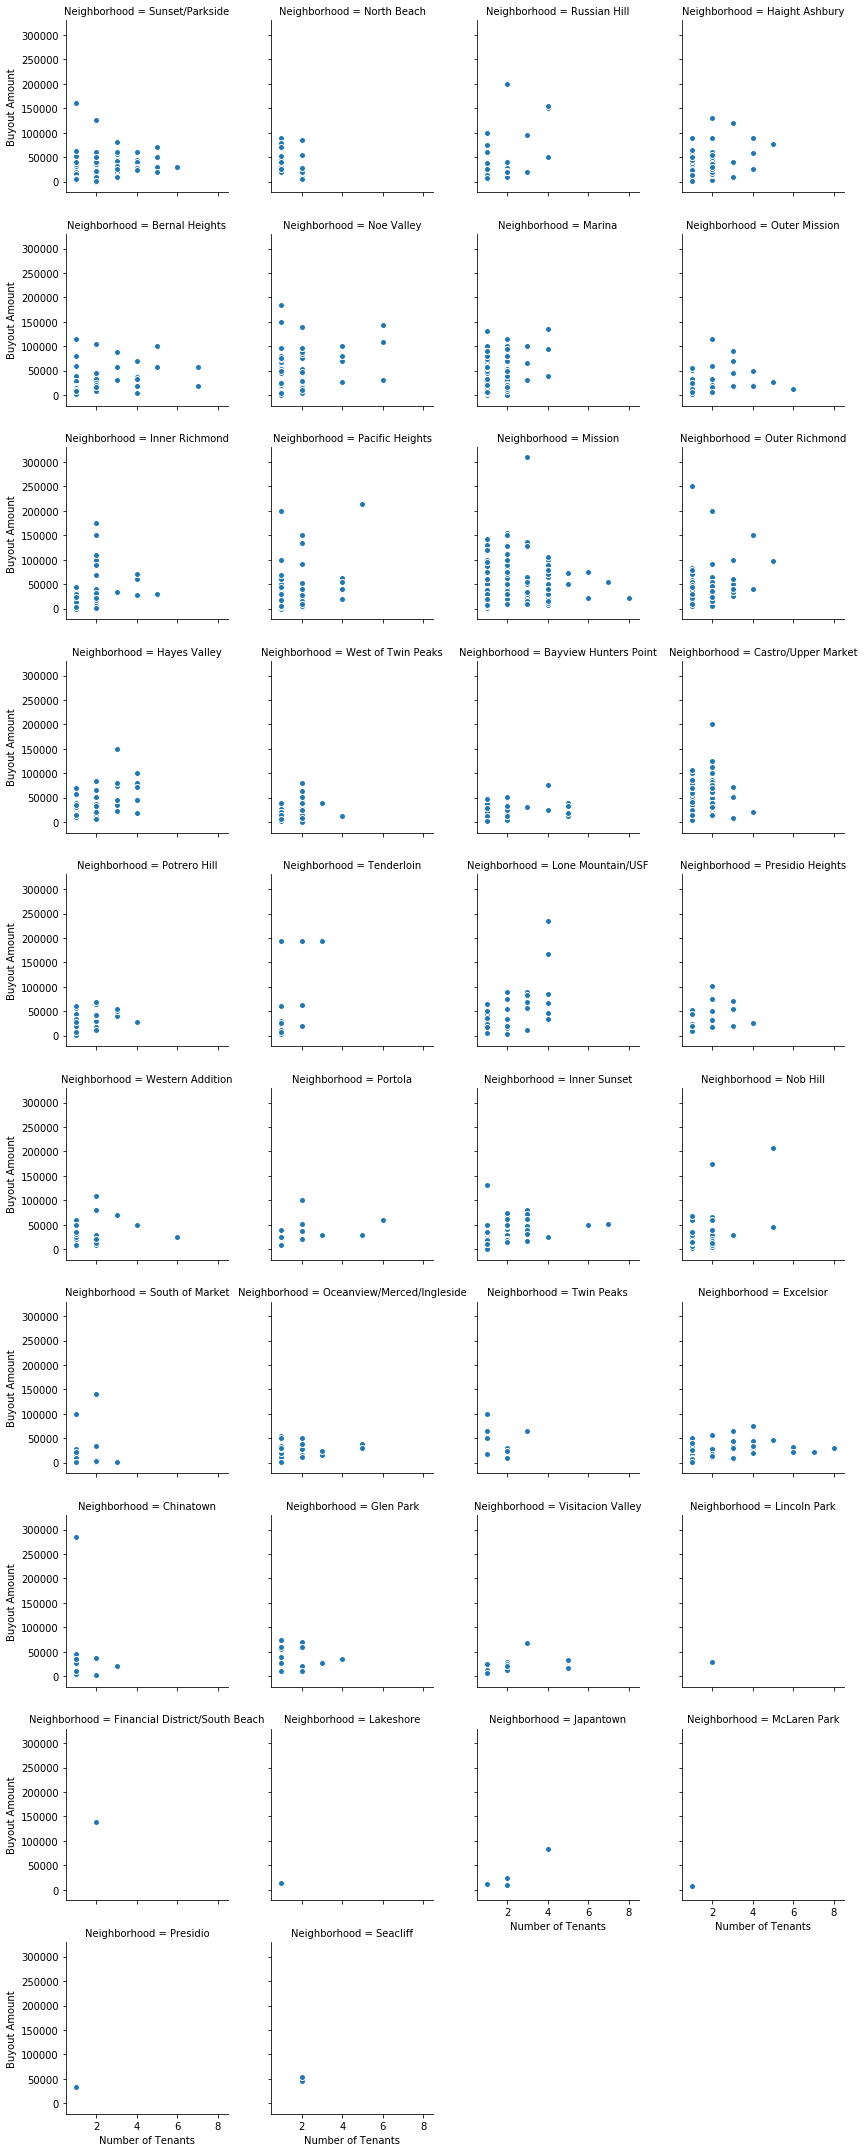

In [10]:
# Create concentration vs precip scatterplots 
g = sns.FacetGrid(buyout, col='Neighborhood', col_wrap=4, height=3)
g = g.map(plt.scatter,'Number of Tenants','Buyout Amount', edgecolor = 'w')

In [11]:
buyout.groupby('Number of Tenants').describe()

Buyout Amount                                        \
                          count          mean           std       min   
Number of Tenants                                                       
1                         593.0  38645.220236  38687.326532      0.00   
2                         471.0  41131.053970  36828.424840      0.00   
3                         111.0  50808.678559  39834.107756    475.00   
4                          89.0  55300.244494  39829.458886   5000.00   
5                          28.0  54430.489643  49890.234069  12100.00   
6                          12.0  50563.461667  39903.517717  11938.32   
7                           5.0  40440.400000  19223.794131  18000.00   
8                           2.0  25416.670000   6481.807447  20833.34   

                                                              
                         25%       50%         75%       max  
Number of Tenants                                             
1                  13000.000  27000.00  51286.0300  285000.0  
2                  17500.000  30000.00  51202.0000  200000.0  
3                  28971.500  45000.00  62712.3900  310000.0  
4                  27000.000  42000.00  75000.0000  235000.0  
5                  30000.000  35265.50  59875.0000  214600.0  
6                  23649.250  31000.00  64091.9175  142517.0  
7                  21000.000  51702.00  55000.0000   56500.0  
8                  23125.005  25416.67  27708.3350   30000.0

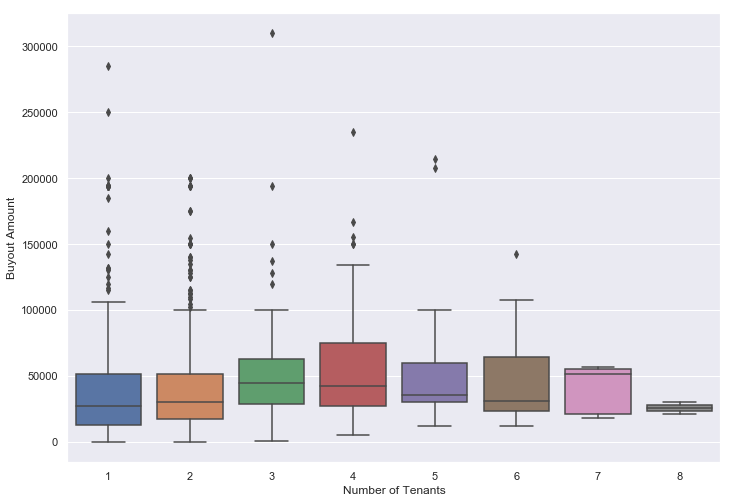

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='Number of Tenants', y='Buyout Amount', data=buyout)

Text(0, 0.5, 'Buyout Count')

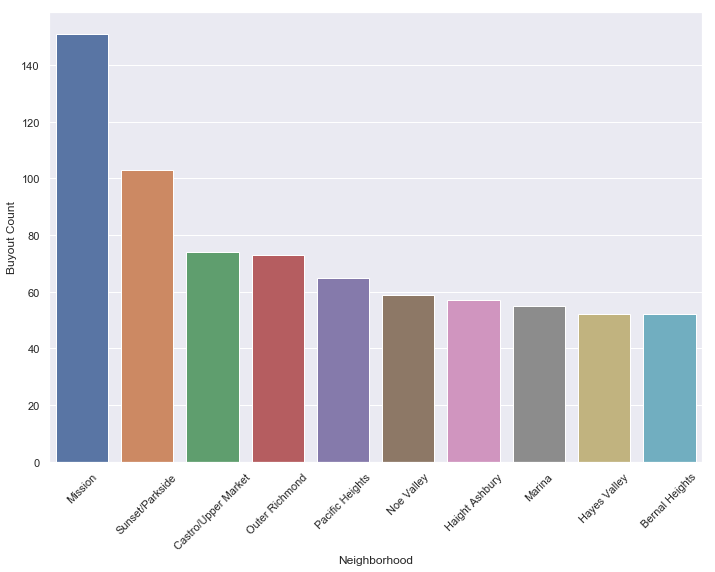

In [13]:
neigh_count = buyout.groupby('Neighborhood').count().sort_values('Buyout Amount', ascending=False)
neigh_count = neigh_count.reset_index()
neigh_count = neigh_count.head(10)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='Neighborhood', y='Buyout Amount', data=neigh_count)
plt.xticks(rotation=45)
plt.ylabel("Buyout Count")

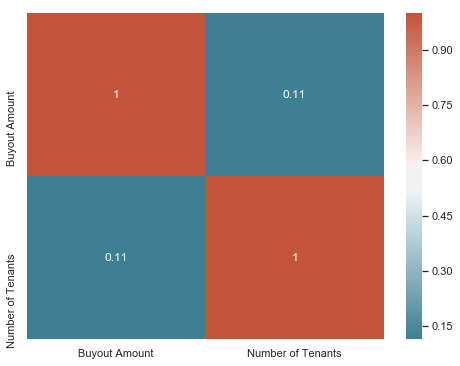

In [14]:
# Generate feature heatmap
corr = buyout.corr()
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True,
            cmap=cmap,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [15]:
buyout.head(1)

,Buyout Amount,Number of Tenants,ZIP Code,Neighborhood
0,18316.2,1,94116,Sunset/Parkside


In [16]:
def buyout_calculator(neighborhood, tenants):
    """ San Francisco buyout generator
    
    Keyword argurments:
    neighborhood -- neighborhood (must be string)
    tenants -- number of tenants
    """

    # Select location
    selected = buyout[buyout['Neighborhood'] == neighborhood]

    #Assign target and features,
    X = selected['Number of Tenants']
    y = selected['Buyout Amount']
    X = np.array(X).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    

    #Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

    #Evaluate models with Root Mean Squared Error
    def rmse(actuals, preds):
        return np.sqrt(((actuals - preds) ** 2).mean())

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    print("RMSE: ", rmse(lr.predict(X_test), y_test))
    r = lr.score(X_train, y_train)
    print("R^2: ", r)
    
    
    reshaped = np.array(tenants).reshape(-1,1)
    amount = lr.predict(reshaped)
    print("Buyout estimate: ", amount[0][0])


In [24]:
buyout_calculator('Noe Valley', 2)

RMSE:  27773.340082630308
R^2:  0.06077308466729159
Buyout estimate:  57287.32494729444


In [18]:
buyout_calculator('Mission', 3)

RMSE:  38580.08200767053
R^2:  0.004317340052893415
Buyout estimate:  56192.5300078906


In [19]:
buyout_calculator('Inner Richmond', 4)

RMSE:  45346.910092797814
R^2:  0.07951821476133314
Buyout estimate:  53249.27775641026


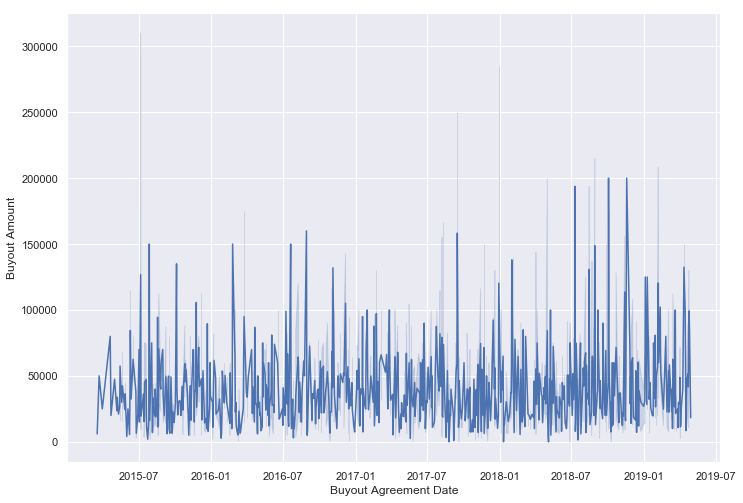

In [20]:
# Time Series
SF = SF_buy
SF['Buyout Agreement Date'] = pd.to_datetime(SF_buy['Buyout Agreement Date'])
sns.lineplot(x='Buyout Agreement Date', y='Buyout Amount', data=SF)

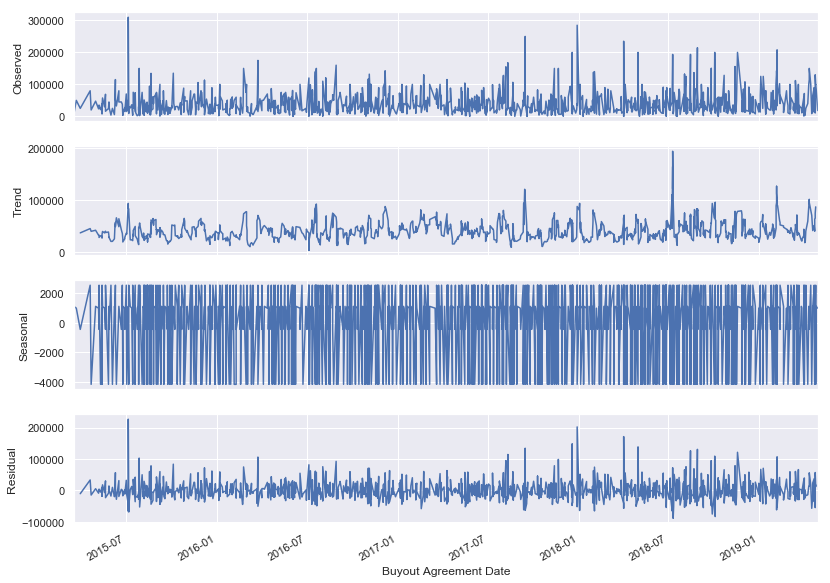

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
SF_time = SF.iloc[:, [2,3]]
SF_time = SF_time.dropna()
SF_time = SF_time.set_index('Buyout Agreement Date') #Reset index for decomposition 
SF_time.index = pd.to_datetime(SF_time.index)


target = SF_time['Buyout Amount']
decomp = seasonal_decompose(target, freq=5)
decomp.plot()
plt.show()

In [22]:
# Future Work
# Need length of tenant stay
# Tie in block home value
# Perform DB scan

In [23]:
buyout_dumm = pd.get_dummies(buyout[['ZIP Code', 'Neighborhood']])
cleaned_sf = pd.concat([buyout, buyout_dumm], axis=1).\
            drop(columns=['ZIP Code', 'Neighborhood'])
cleaned_sf.head()
rf = RandomForestRegressor(n_estimators = 100, max_features = 3, n_jobs=-1)
rf.fit(X_train,y_train)
rmse(rf.predict(X_test), y_test)

NameError: name 'X_train' is not defined